In [9]:
# 다운받은 API Token 업로드 하기
!pip install kaggle

from google.colab import files # → 이미 (만기되지 않은 Token이) 업로드 되어있다면 생략
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mongnyonglee","key":"1f9b2690a6d131428bb2bba9507233af"}'}

In [10]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle competitions download -c bike-sharing-demand

# 다운로드 된 것들 다 보기 
!ls

  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 45.9MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 89.8MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 43.1MB/s]
kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


In [17]:
# 한글 글꼴 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
# 반드시 런타임 다시 시작

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그려주기 위해 (colab환경에선 생략 가능)
%matplotlib inline

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [19]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [20]:
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [39]:
# test 파일에는 어떤 칼럼이 빠져있는 지 확인
[col for col in train.columns if col not in test.columns]

['casual', 'registered', 'count']

우선 `['casual', 'registered', 'count']` 칼럼들이 빠져있는 것을 보니 train의 이 칼럼들은 feature로 사용하기 힘든 부분이 있습니다.

> 내 생각: 만약 일반 사용자와 회원의 이용률이 상당히 차이가 난다면? 아니여도 정말 버려도 되는 정보인가?

## 3. Feature Engineering
먼저 `datetime` 칼럼을 세분화시킵니다. (의도적으로 칼럼을 추가 시킵니다.)

In [40]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [41]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

시간 데이터를 세분화 시켰으니, windspeed의 0값도 예측하여 다른 값으로 대체 가능할 것 같습니다.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: Runti

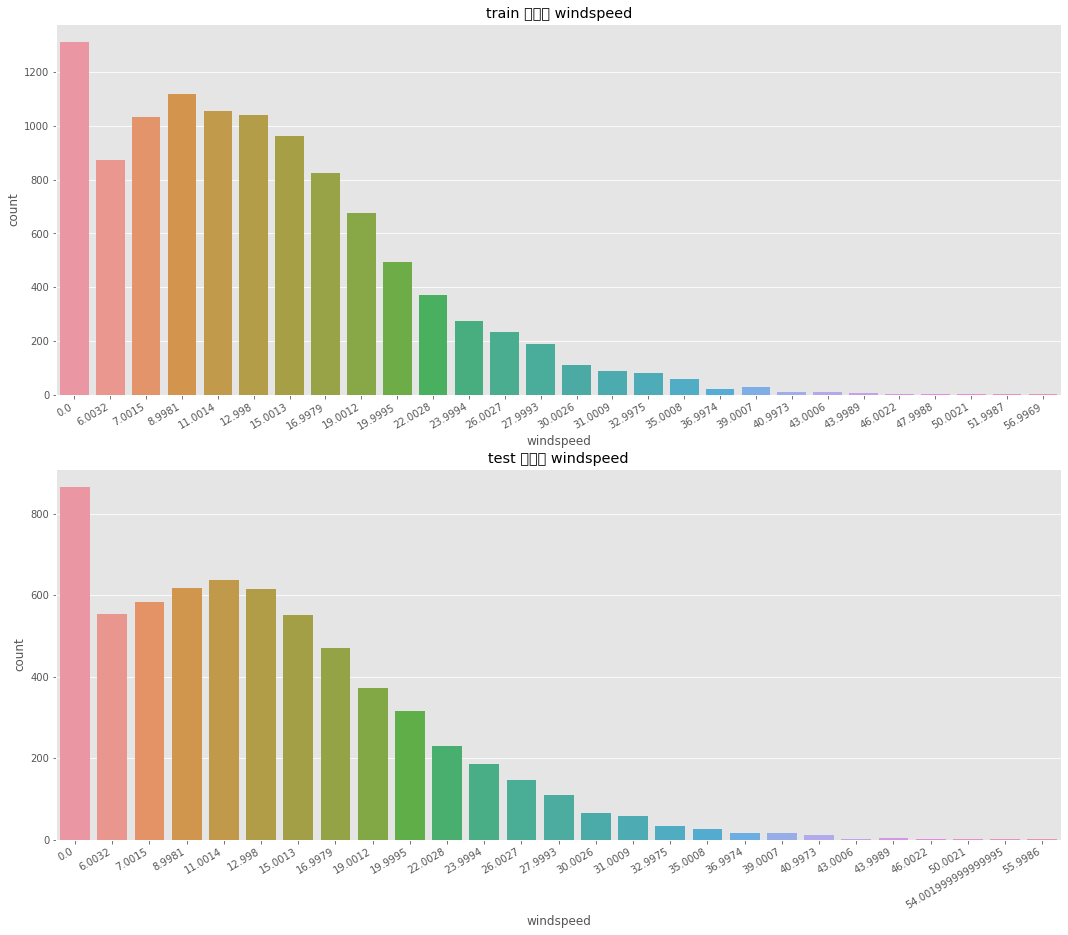

In [42]:
# windspeed 풍속에 0이 가장 많은 것을 보면 → 잘못 기록된 데이터를 고쳐줄 필요가 있음
fig, axes = plt.subplots(nrows = 2)
fig.set_size_inches(18, 15)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train 데이터 windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test 데이터 windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

위 count plot 그래프로 미루어 보아, 알수 있는 점은:
- 0에 (부자연스럽게) 굉장히 많은 데이터가 분포되어 있음 → 결측치일 가능성 있음

따라서, 0인 데이터는 모델 성능을 향상시키기 위해 합리적인 데이터 값을 계산하여 처리하는 것이 나을 수도 있을 것 같다는 생각을 합니다.

그러면 평균 데이터로 대치를 한다면?
```python
train.loc[train['windspeed'] == 0, 'windspeed'] = train['windspeed'].mean()
test.loc[test['windspeed'] == 0, 'windspeed'] = test['windspeed'].mean()
```
모델 향상에 그렇게 도움이 되진 않을 것 같아서 다른 방법을 고안해냅니다.

우선 windspeed가 0인 것과 0이 아닌 것으로 데이터를 나눕니다.

In [43]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]

print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [44]:
# 풍속이 0이 아닌 것의 데이터로 머신러닝하여 풍속이 0인 것의 데이터 값을 Imputation하기
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    ## Step1: 데이터 가공
    # 풍속이 0인 것과 0이 아닌 것 나누기
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 feature 선택 → 현재 예측하는 데 참고할 수 있는 데이터는 날씨 데이터 이므로
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

    # 풍속이 0이 아닌 데이터들의 풍속 데이터 타입을 float → str 변환 (WHY??)
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

    ## Step2: 모델 생성, 학습
    # 랜던포레스트 분류기 객체 생성
    rfModel_wind = RandomForestClassifier()

    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed']) # fit(DataFrame(x), Series(y))

    ## Step3: 예측
    wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

    ## Step4: 검증
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    predictWind0['windspeed'] = wind0Values

    # 0이 아닌 값으로 채워진 predictWind0를 predictWindNot0와 합치기 (train 데이터 수가 많으면 정보가 많아 모델 향상에 도움이 될 수 있음)
    data = predictWindNot0.append(predictWind0)

    # 다시 변환
    data['windspeed'] = data['windspeed'].astype('float')

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

> 내 생각:
- `temp`와 `atemp`서로 강력한 상관관계가 있다는 것을 보아 다중공선성이 있다는 것이 우려되어 변수를 제거하는 등의 조취를 취해야할 것 같다.
- 왜 float → str → float 변환을 했지?

이제 방금 생성된 함수를 train 데이터에 적용해보도록 하겠습니다.
(※ test 데이터에 적용하는 것은 보류 → 평가 점수가 낮아짐)

In [45]:
# 방금 생성한 함수 적용 (0데이터 치환)
train = predict_windspeed(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


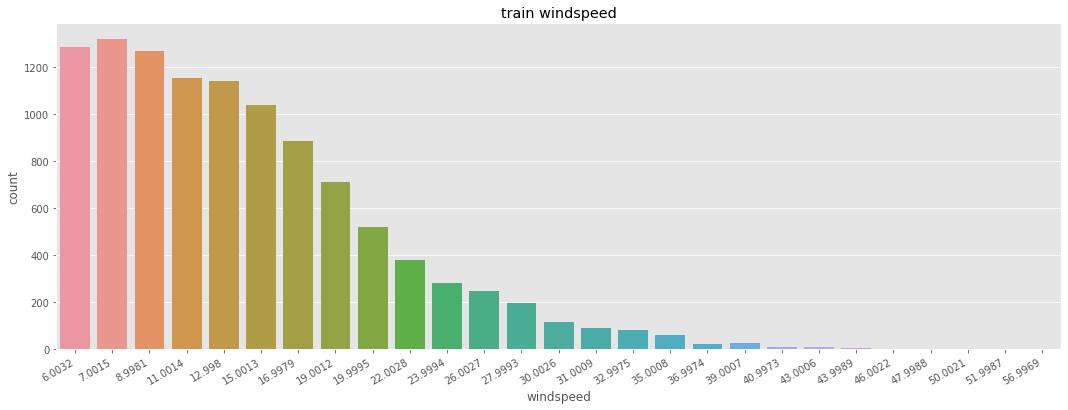

In [46]:
#함수 적용 후 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

확실히 0인 데이터는 보여지지 않으며 대부분 데이터가 적은 수쪽에 몰려있음을 확인 할 수 있습니다.

## 4. [Feature Selection](https://subinium.github.io/feature-selection/)
모델에 사용될 feature 변수 칼럼을 선택해야 합니다. 변수 선택 기준은:
- 신호와 잡음을 구분해야 된다.
- feature가 많다고 해서 무조건 좋은 성능을 내지 않는다.
- feature를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.
- 변수의 유형 (수치형, 범주형) 구분 필수.

범주형 변수 같은 경우 수치로 나타내고 싶다면 One-hot encoding을 사용하는 방법이 있습니다.

In [47]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [48]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity','windspeed',
                 'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [49]:
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [50]:
x_test = test[feature_names]

print(x_test.shape)
x_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [51]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [52]:
# 모델 평가 함수 생성
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # Numpy array(ndarray)형태로 변환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제값에 1을 더하고 로그를 씌워준다
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱해준다.
    diff = log_predict - log_actual
    diff = np.square(diff) # diff ** 2

    # 평균
    mean_diff = diff.mean()

    # 루트를 씌운다.
    score = np.sqrt(mean_diff)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### RandomForest

In [54]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

[`%time`](https://www.rlee.ai/jupyter-notebook-profiler-1)이란 한 줄의 코드의 실행시간을 측정할 때 쓸 수 있습니다. 단순히 측정할 줄 앞에 `%time`을 붙이면 됩니다.

In [55]:
%time score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

print('Score = {0:.5f}'.format(score))

CPU times: user 3.37 s, sys: 691 ms, total: 4.06 s
Wall time: 30.8 s
Score = 0.33058


### Train data로 학습

In [56]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [57]:
predict = model.predict(x_test)

print(predict.shape)
predict[0:10]

(6493,)


array([ 12.5 ,   5.2 ,   3.98,   3.61,   3.22,   6.41,  37.85, 105.65,
       236.38, 136.44])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

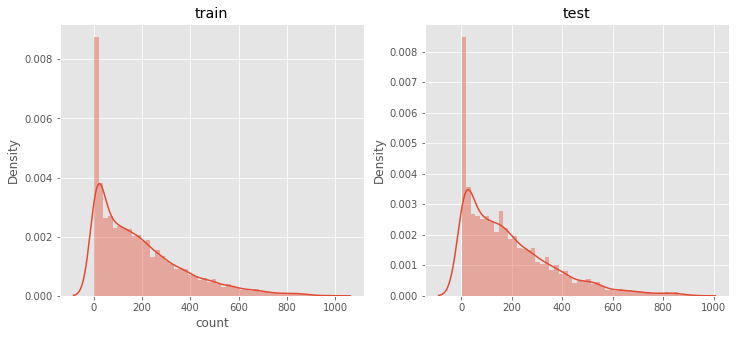

In [58]:
# 예측 데이터 시각화
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predict, ax=ax2, bins=50)
ax2.set(title='test')

## Submission

In [59]:
submission = pd.read_csv('sampleSubmission.csv')
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [60]:
submission['count'] = predict

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.50
1,2011-01-20 01:00:00,5.20
2,2011-01-20 02:00:00,3.98
3,2011-01-20 03:00:00,3.61
4,2011-01-20 04:00:00,3.22


In [61]:
submission.to_csv('Score_{0:.5f}_submission.csv'.format(score), index=False)